<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/Standard_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_5_OLCI_radiance_reflectance_spectra.ipynb" target="_blank"><< OLCI radiance and reflectance spectra</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="1_7_OLCI_light_environment.ipynb" target="_blank">Assessing the light environment >></a>

<font color="#138D75">**Copernicus Marine Training Service**</font> <br>
**Copyright:** 2022 EUMETSAT <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h3>Learn OLCI: Introductory</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
The following modules are prerequisites for this notebook, and will retrieve the data required here.
  - **<a href="./1_1a_OLCI_data_access_Data_Store.ipynb" target="_blank">1_1a_OLCI_data_access_Data_Store.ipynb</a>** if using the Data Store for data access
    <br><br>**OR**<br><br>
  - **<a href="./1_1b_OLCI_data_access_HDA.ipynb" target="_blank">1_1b_OLCI_data_access_HDA.ipynb</a>** if using WEkEO for data access
    
</div>
<hr>

# 1.6 Comparing OLCI chlorophyll products


### Data used

| Product Description | Data Store collection ID| Product Navigator | WEkEO HDA ID | WEkEO metadata |
|:--------------------:|:-----------------------:|:-------------:|:-----------------:|:-----------------:|
| Sentinel-3 OLCI level-2 full resolution | EO:EUM:DAT:0407 | <a href="https://navigator.eumetsat.int/product/EO:EUM:DAT:SENTINEL-3:OL_2_WFR___NTC?query=OLCI&filter=satellite__Sentinel-3&filter=instrument__OLCI&filter=processingLevel__Level%202%20Data&s=advanced" target="_blank">link</a> | EO:EUM:DAT:SENTINEL-3:OL_2_WFR___ | <a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AEUM%3ADAT%3ASENTINEL-3%3AOL_1_EFR___" target="_blank">link</a> |

### Learning outcomes

At the end of this notebook you will know;
* About the different algorithms used to provide estimates of chlorophyll-a from OLCI data
* How to plot chlorophyll-a data on a map, with appropriate flags applied


### Outline

The primary objective of ocean colour satellite missions has historically been to estimate the concentration of chlorophyll-a in ocean waters. Inherent in the function of the chlorophyll-a pigment as it has evolved for photosynthesis, is interaction with sunlight. This makes it readily observable by satellite ocean colour instruments. In the simplest understanding of how chlorophyll-a affects the colour of ocean waters, bluer waters tend to have lower concentrations of chlorophyll-a, whilst greener waters have higher concentrations. This simple relationship underlies many of the algorithms used to estimate chlorophyll-a concentrations from ocean colour data, particularly in the open ocean. However, gaining accurate chlorophyll-a concentrations throughout the global oceans is more complicated in reality, and the relationships between the reflectance spectra and chlorophyll-a concentration vary, depending on the characteristics of the phytoplankton assemblage that is the source of the chlorophyll-a, as well as the relative concentrations of other constituents (sediments, dissolved organic matter etc). 

In this notebook we'll look at two different algorithm approaches used to generate chlorophyll-a concentrations in OLCI products, and examine where and when it is most appropriate to use each one, and what their limitations are.

<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>
    
 1. [OLCI Chlorophyll products and algorithms](#section1)
 2. [Reading OLCI chlorophyll data](#section2)
 3. [Understanding and applying flags](#section3)
 4. [Plotting and comparing chlorophyll](#section4)

<hr>

Let's begin by importing all the Python libraries we need for this notebook.

In [1]:
import cartopy.crs as ccrs          # a library that support mapping
import glob                         # a library that aids in searching for files
import matplotlib.pyplot as plt     # a library that support plotting
import matplotlib.ticker as mticker # a library that extends plotting support
import numpy as np                  # a library that provides support for array-based mathematics
import os                           # a library that allows us access to basic operating system commands like making directories
import warnings                     # a library that helps us manage warnings
import xarray as xr                 # a library that supports the use of multi-dimensional arrays in Python
import eumartools                   # a EUMETSAT library that support working with Sentinel-3 products
warnings.filterwarnings('ignore')

# set plot font size
plt.rcParams.update({'font.size': 12})

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. OLCI Chlorophyll products and algorithms
[Back to top](#TOC_TOP)

</div>

Chlorophyll-a concentrations are provided in the OLCI level-2 products. You can find detailed information about these products in the relevant pages of the <a href="https://eumetsatspace.atlassian.net/wiki/spaces/SEN3/pages/1597767909/OLCI+products+level-2" target="_blank">Sentinel-3 knowledge base</a>


The two products are called:
* CHL_OC4ME
* CHL_NN

The CHL_OC4ME is an algorithm based on an empirical relationship between reflected light measured at several of the blue and green wavebands of OLCI, and in situ measurements of chlorophyll-a concentration. It is applied to reflectances derived from the Baseline Atmospheric Correction (BAC) processing chain. 

The CHL_NN is an output of the alternative atmospheric correction and comples water processing chain. It involves several neural networks which retrieve the reflectances (not supplied in the standard level-2 OLCI products) and several geophysical products including the chlorophyll-a concentraion, total suspended matter (TSM) concentration, and an estimate of the absorption by coloured dissolved organic matter at detritus at 443 nm. 

You can find more details on both processing chains in the the OLCI level-2 processing pages of the <a href="https://eumetsatspace.atlassian.net/wiki/spaces/SEN3/pages/1597800556/OLCI+processing+level-2" target="_blank">Sentinel-3 knowledge base</a>. The complex water process (C2RCC) is also available in the <a href="https://step.esa.int/main/toolboxes/snap/" target="_blank">Sentinel-Applications Platform (SNAP)</a>.

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Reading OLCI chlorophyll data
[Back to top](#TOC_TOP)

</div>

To begin with, we'll create paths that point to the location of our data of interest.

In [2]:
SAFE_directory = os.path.join(os.getcwd(), 'products',
    'S3A_OL_2_WFR____20210717T101015_20210717T101315_20210718T221347_0179_074_122_1980_MAR_O_NT_003.SEN3')

Next we'll set a parameter to reduce the resolution of the data we are working with. For analyses you would not want to do this, but it will help us to visualise our data much faster in the context of this tutorial notebook.

In [3]:
grid_reduce = 5

Then, we'll open the data we need including the latitude and longitude information, and the two chlorophyll-a products. We'll also calculate the difference between the two chlorphyll-a products.

In [4]:
geo_file = os.path.join(SAFE_directory,'geo_coordinates.nc')
geo_fid = xr.open_dataset(geo_file)
lon = geo_fid.longitude.data[::grid_reduce, ::grid_reduce]
lat = geo_fid.latitude.data[::grid_reduce, ::grid_reduce]
geo_fid.close()

In [5]:
band_vars = xr.open_mfdataset(glob.glob(os.path.join(SAFE_directory,'chl*.nc')))
band_vars["CHL_DIFF"] = 10**band_vars['CHL_OC4ME'] - 10**band_vars['CHL_NN']
band_vars.close()

<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Understanding and applying flags
[Back to top](#TOC_TOP)

</div>

As well as the data and the geocoordinates, to plot geophysical products derived from OLCI properly, we also need to extract and apply the relevant quality flags. Below you can see that the flags are extracted from the wqsf netcdf file. If we print out the flags and their associated Bit values, you can get an idea about what they represent, and how to access each individual one.

In [6]:
flag_file = os.path.join(SAFE_directory,'wqsf.nc')
flag_vars = xr.open_dataset(flag_file)
flag_vars.close()
band_vars["WQSF"] = flag_vars["WQSF"]

ii = np.argsort(flag_vars["WQSF"].flag_masks)
bitvals = np.array(flag_vars["WQSF"].flag_masks)[ii]
meanings = np.array(flag_vars["WQSF"].flag_meanings.split(' '))[ii]

print("Bit   Bitval                 BitMeaning")
for bitval, meaning, bit in zip(bitvals, meanings, np.arange(len(bitvals))):
    print(f"{str(bit).zfill(2)}    {str(bitval).zfill(20)}   {meaning}")

Bit   Bitval                 BitMeaning
00    00000000000000000001   INVALID
01    00000000000000000002   WATER
02    00000000000000000004   LAND
03    00000000000000000008   CLOUD
04    00000000000000000016   SNOW_ICE
05    00000000000000000032   INLAND_WATER
06    00000000000000000064   COASTLINE
07    00000000000000000128   TIDAL
08    00000000000000000256   COSMETIC
09    00000000000000000512   SUSPECT
10    00000000000000001024   HISOLZEN
11    00000000000000002048   SATURATED
12    00000000000000004096   MEGLINT
13    00000000000000008192   HIGHGLINT
14    00000000000000016384   WHITECAPS
15    00000000000000032768   ADJAC
16    00000000000000065536   WV_FAIL
17    00000000000000131072   PAR_FAIL
18    00000000000000262144   AC_FAIL
19    00000000000000524288   OC4ME_FAIL
20    00000000000001048576   OCNN_FAIL
21    00000000000002097152   KDM_FAIL
22    00000000000004194304   TURBID_ATM
23    00000000000008388608   CLOUD_AMBIGUOUS
24    00000000000016777216   CLOUD_MARGIN
25    0

We'll use a quick function from the eumar tools library that allows us to read in the flag information simply by supplying the name (Bitmeaning as listed above). First we'll read in land, then a series of flags that all relate to cloud. 

If you want to look in detail at this function, you can add another code cell below and run the following command: print(inspect.getsource(eumartools.flag_mask.)) 

In [7]:
# reading masks: example land
land_mask = eumartools.flag_mask(flag_file, 'WQSF', ['LAND'])
land_mask = land_mask.astype(float)[::grid_reduce, ::grid_reduce]
land_mask[land_mask == 0.0] = np.nan

In [8]:
# reading masks: example cloud
cloud_mask = eumartools.flag_mask(flag_file, 'WQSF', ['CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN'])
cloud_mask = cloud_mask.astype(float)[::grid_reduce, ::grid_reduce]
cloud_mask[cloud_mask == 0.0] = np.nan

We'll create a combine mash by reading in all the flags that are relevant for both the CHL_OC4ME and CHL_NN products. These lists are the recommended flags provided by EUMETSAT. You can find out more about them [here](https://eumetsatspace.atlassian.net/wiki/spaces/SEN3/pages/1688829976/OLCI+level-2+flags).

In [9]:
# reading masks: all flags BAC recommended
BAC_mask = eumartools.flag_mask(flag_file, 'WQSF', ['LAND', 'CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 
                                                    'INVALID', 'COSMETIC', 'SATURATED', 'SUSPECT',
                                                    'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE', 'AC_FAIL',
                                                    'WHITECAPS', 'ADJAC', 'RWNEG_O2', 'RWNEG_O3',
                                                    'RWNEG_O4', 'RWNEG_O5', 'RWNEG_O6', 'RWNEG_O7', 'RWNEG_O8',
                                                    'OC4ME_FAIL'])
BAC_mask = BAC_mask.astype(float)[::grid_reduce, ::grid_reduce]
BAC_mask[BAC_mask == 0.0] = np.nan

In [10]:
# reading masks: all flags NN recommended
NN_mask = eumartools.flag_mask(flag_file, 'WQSF', ['LAND', 'CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 
                                                    'INVALID', 'COSMETIC', 'SATURATED', 'SUSPECT',
                                                    'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE', 'AC_FAIL',
                                                    'WHITECAPS', 'ADJAC', 'RWNEG_O2', 'RWNEG_O3',
                                                    'RWNEG_O4', 'RWNEG_O5', 'RWNEG_O6', 'RWNEG_O7', 'RWNEG_O8',
                                                    'OCNN_FAIL'])
NN_mask = NN_mask.astype(float)[::grid_reduce, ::grid_reduce]
NN_mask[NN_mask == 0.0] = np.nan

<div class="alert alert-info" role="alert">

## <a id='section4'></a>4. Plotting and comparing chlorophyll
[Back to top](#TOC_TOP)

</div>

Now that we've read in both the data we're interested in, and the flags to creat a mask, we can plot the data on a map...

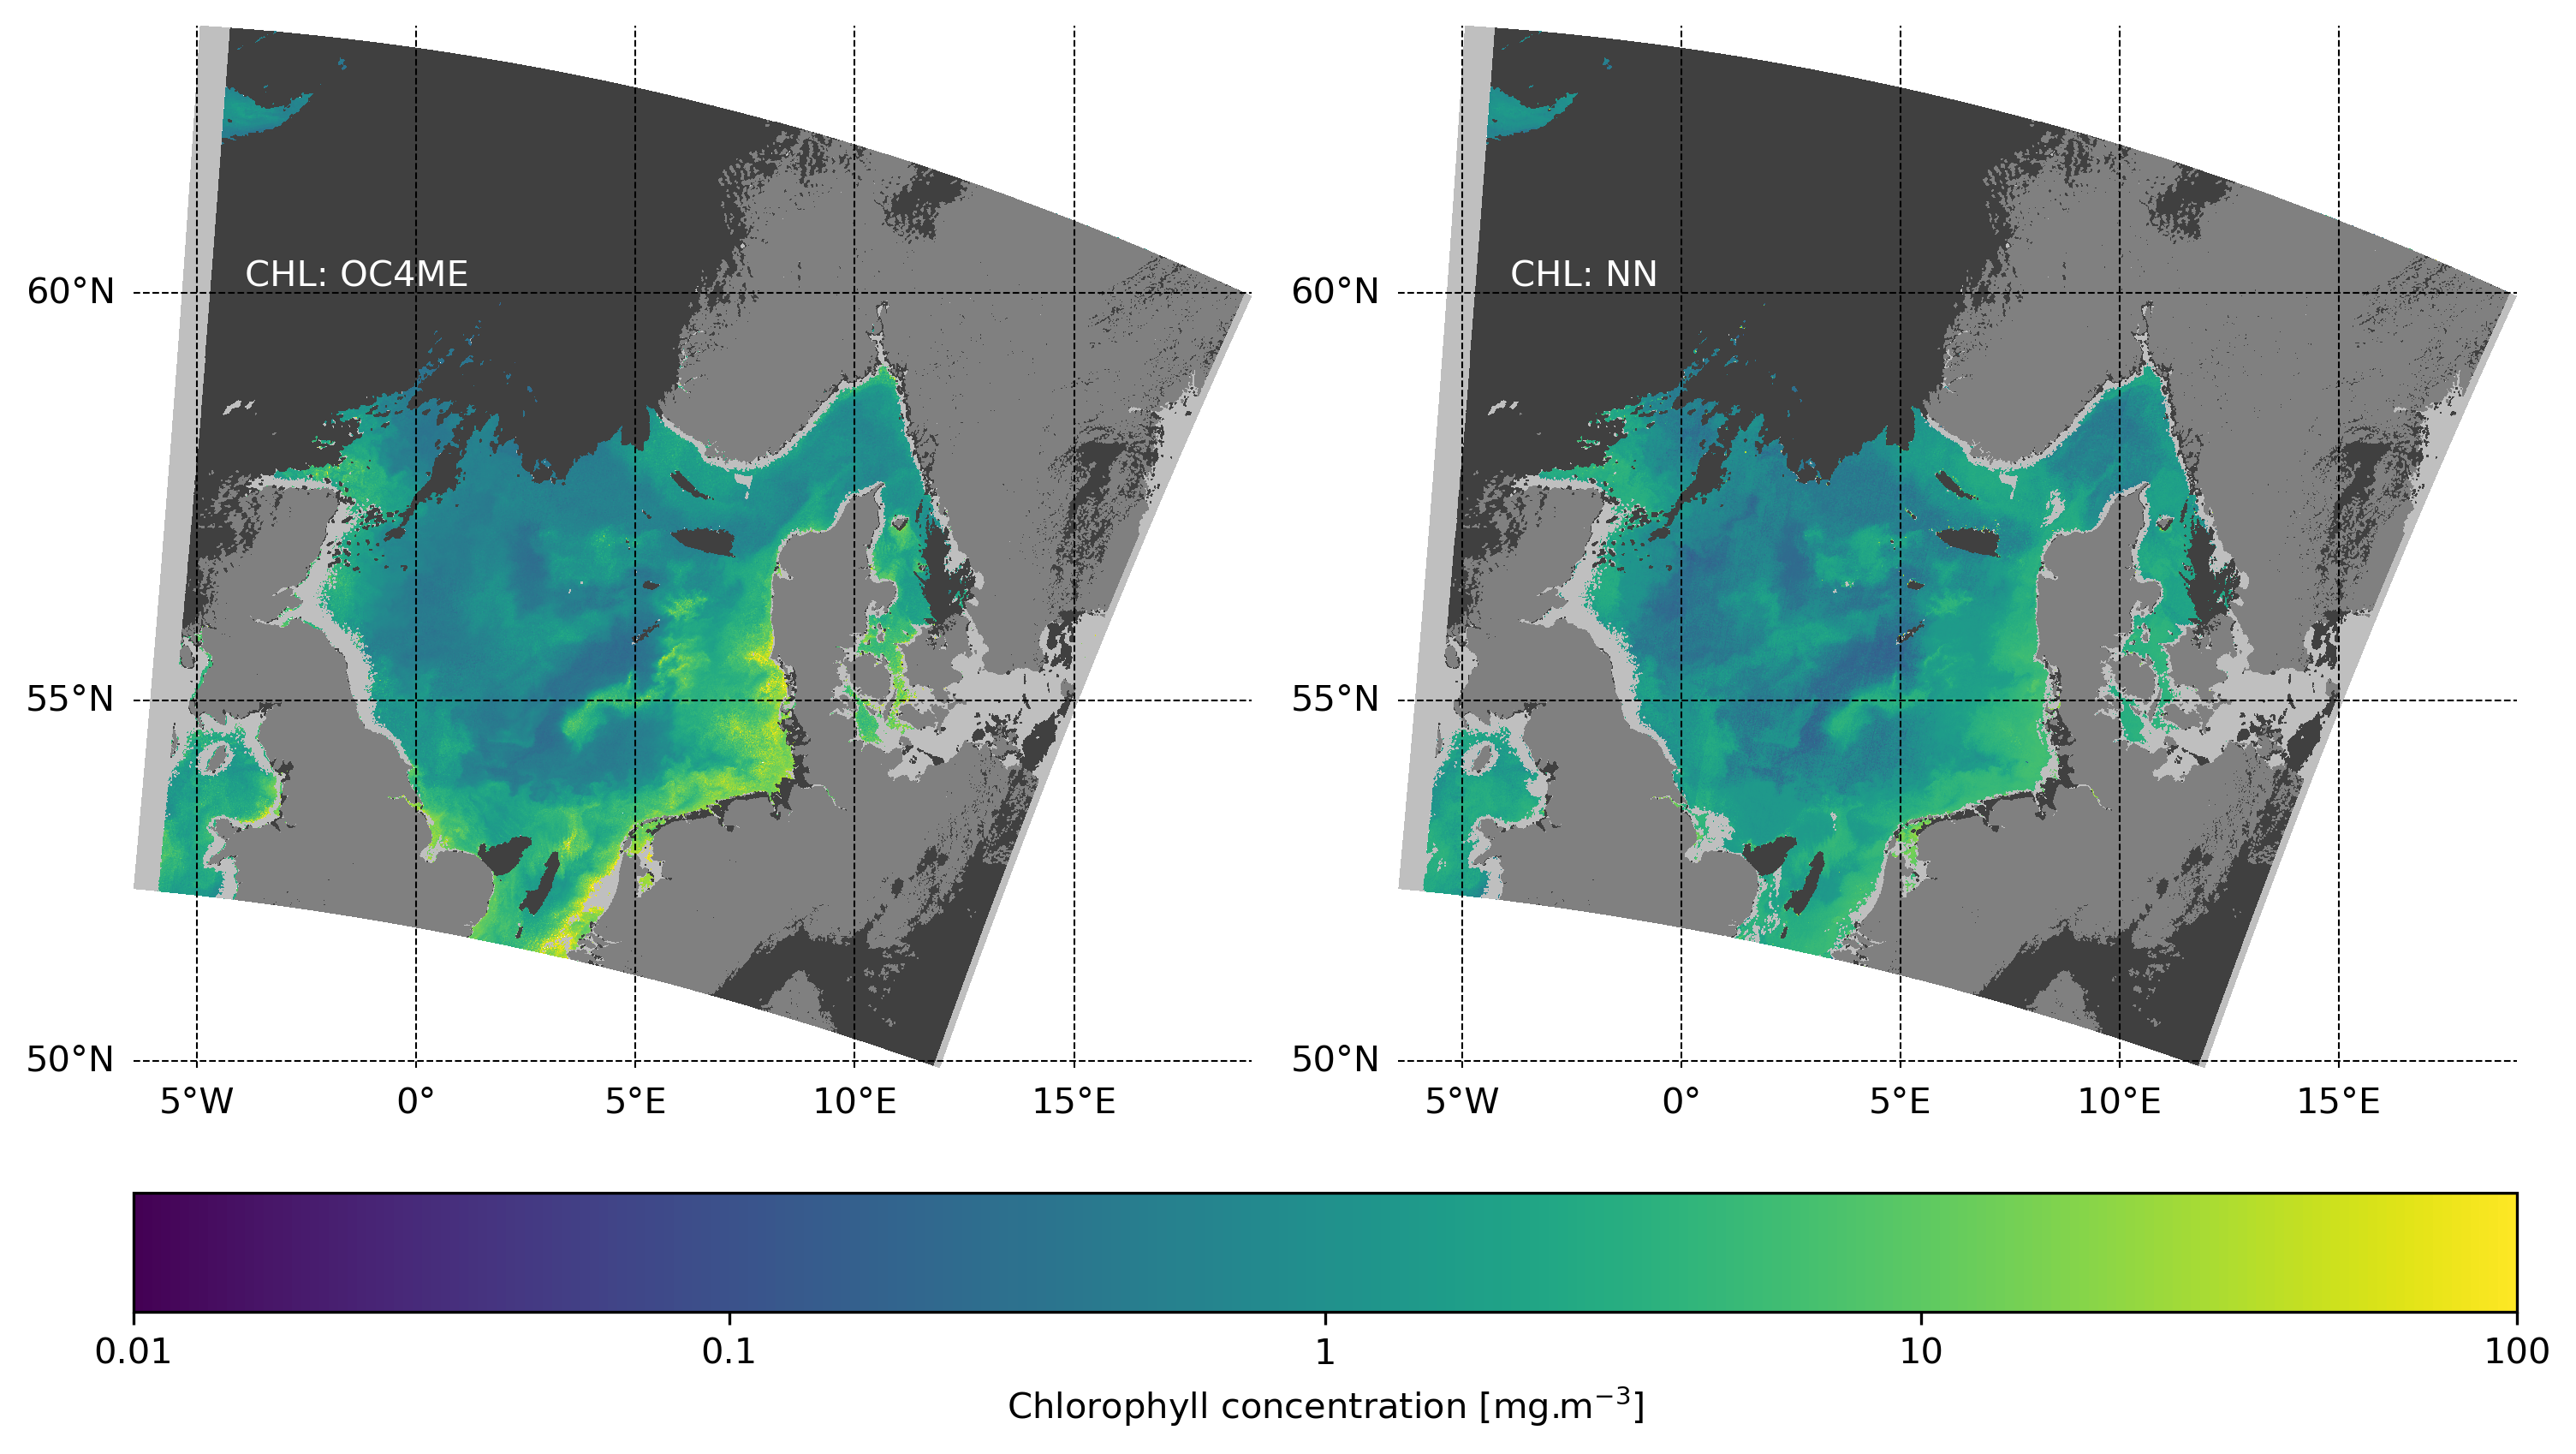

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10), dpi=300, subplot_kw={"projection": ccrs.Mercator()})

for m, var, cmap, all_mask in zip(axs.reshape(-1),
                         ['CHL_OC4ME', 'CHL_NN'],
                         ['viridis','viridis'],[BAC_mask, NN_mask]):
    
    p1 = m.pcolormesh(lon, lat, band_vars[var][::grid_reduce, ::grid_reduce], transform=ccrs.PlateCarree(), 
                       cmap=cmap, vmin=-2, vmax=2, zorder=1)

    m.contourf(lon, lat, all_mask, levels=[0,1], transform=ccrs.PlateCarree(), colors='0.75', zorder=2)
    m.contourf(lon, lat, cloud_mask, levels=[0,1], transform=ccrs.PlateCarree(), colors='0.25', zorder=3)
    m.contourf(lon, lat, land_mask, levels=[0,1], transform=ccrs.PlateCarree(), colors='0.5', zorder=4)

    m.annotate(f"{var.replace('_',': ')}", xy=(0.1, 0.75), xycoords='axes fraction',
            transform=ccrs.PlateCarree(), zorder=30, color='w')

    # Embellish with gridlines
    g1 = m.gridlines(draw_labels = True, zorder=20, color='0.0', linestyle='--', linewidth=0.5)
    g1.xlocator = mticker.FixedLocator(np.arange(-180, 180, 5))
    g1.ylocator = mticker.FixedLocator(np.arange(-90, 90, 5))
    g1.top_labels = False
    g1.right_labels = False
    g1.xlabel_style = {'color': 'black'}
    g1.ylabel_style = {'color': 'black'}
    m.set(facecolor = "1.0")
    m.axis('off')

plt.tight_layout()

cbar = fig.colorbar(p1, ax=axs[:], location='bottom', pad=0.05)
ticks = [-2,-1,0,1,2]
cbar.set_ticks(ticks)
cbar.set_ticklabels([10**tick for tick in ticks])
cbar.set_label('Chlorophyll concentration [mg.m$^{-3}$]')
plt.savefig('1_6_OLCI_CHL.png', bbox_inches='tight')

In the figure you can see that whilst the general patterns are similar, there are some noticeable differences between the two algorithms, particularly in the coastal regions. You can also see some differences in the flags. The dark grey cloud mask is the same applied to both images, as is the land mask, but the combined other flags (light grey) differ, reflecting the different approaches taken by the two algorithms. 

We can look in more detail at the differences by creating a plot showing the difference between the two algorithms...

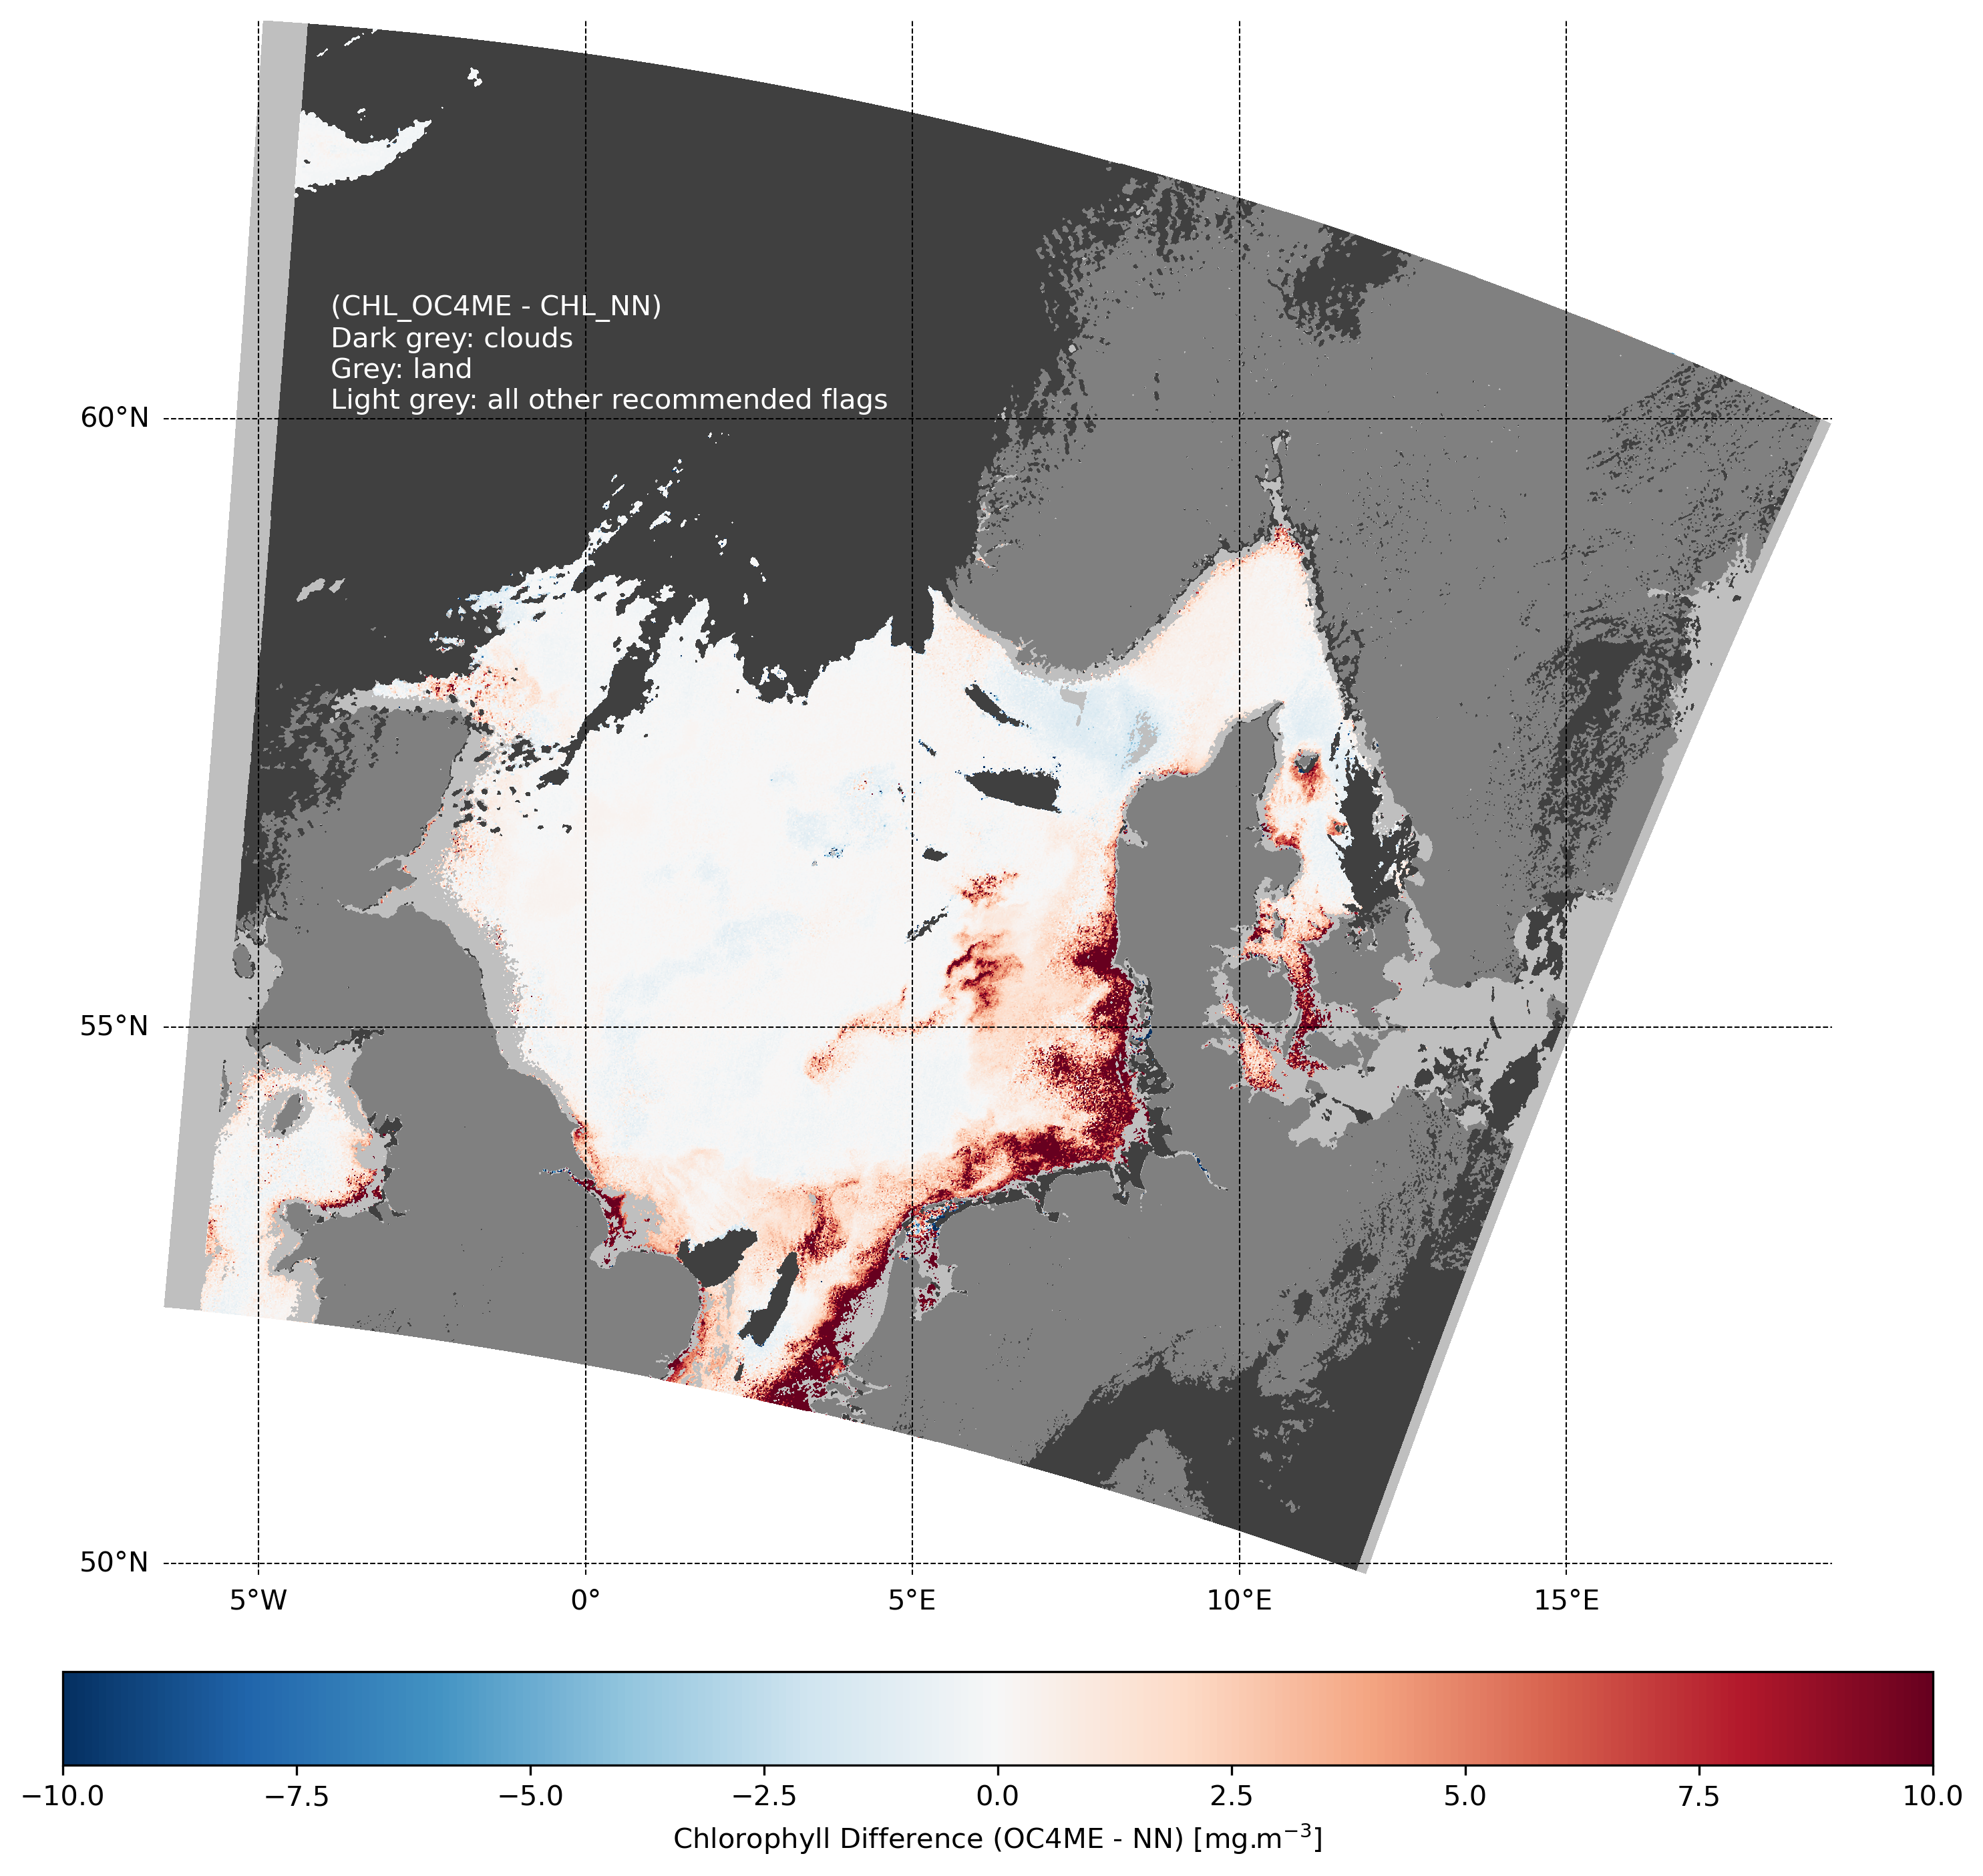

In [12]:
fig = plt.figure(figsize=(10, 10), dpi=300)
m = plt.subplot(projection=ccrs.Mercator())

p1 = m.pcolormesh(lon, lat, band_vars["CHL_DIFF"][::grid_reduce, ::grid_reduce], transform=ccrs.PlateCarree(), 
                   cmap=plt.cm.RdBu_r, vmin=-10, vmax=10, zorder=1)

m.contourf(lon, lat, BAC_mask, levels=[0,1], transform=ccrs.PlateCarree(), colors='0.75', zorder=2)
m.contourf(lon, lat, NN_mask, levels=[0,1], transform=ccrs.PlateCarree(), colors='0.75', zorder=2)
m.contourf(lon, lat, cloud_mask, levels=[0,1], transform=ccrs.PlateCarree(), colors='0.25', zorder=3)
m.contourf(lon, lat, land_mask, levels=[0,1], transform=ccrs.PlateCarree(), colors='0.5', zorder=4)

m.annotate("(CHL_OC4ME - CHL_NN)\nDark grey: clouds\nGrey: land\nLight grey: all other recommended flags",
           xy=(0.1, 0.75), xycoords='axes fraction', transform=ccrs.PlateCarree(), zorder=30, color='w')

# Embellish with gridlines
g1 = m.gridlines(draw_labels = True, zorder=20, color='0.0', linestyle='--',linewidth=0.5)
g1.xlocator = mticker.FixedLocator(np.arange(-180, 180, 5))
g1.ylocator = mticker.FixedLocator(np.arange(-90, 90, 5))
g1.top_labels = False
g1.right_labels = False
g1.xlabel_style = {'color': 'black'}
g1.ylabel_style = {'color': 'black'}
m.set(facecolor = "1.0")
m.axis('off')

cbar = fig.colorbar(p1, location='bottom', pad=0.05)
cbar.set_label('Chlorophyll Difference (OC4ME - NN) [mg.m$^{-3}$]')
plt.tight_layout()
plt.savefig('1_6_OLCI_CHL_diff.png', bbox_inches='tight')

Here we can confirm what was suspected from the two images above. Both algorithms provide similar estimates of chlorophyll-a concentration away from land, however near the coasts, particularly in areas where there is strong sediment presence from rivers or tidal resuspension, the CHL_OC4ME overestimates relative to the CHL_NN. This is likely because the CHL_OC4ME is misattributing signal associated with sediments and coloured dissolved organic matter to chlorophyll-a. In comparison, the CHL_NN, which uses more spectral information, and is trained using data from a wide range of waters, may well be more accurately attributing the signal to sediments in these waters, and less to chlorphyll-a. 

This image nicely summarises the main reasoning for choosing each product. In the open ocean, the CHL_OC4ME product is sufficient for estimating chlorophyll-a, whilst in the coastal oceans, the CHL_NN may be more appropriate.

<hr>
<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_5_OLCI_radiance_reflectance_spectra.ipynb" target="_blank"><< OLCI radiance and reflectance spectra</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="1_7_OLCI_light_environment.ipynb" target="_blank">Assessing the light environment >></a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean" target="_blank">View on GitLab</a> | <a href="https://training.eumetsat.int/" target="_blank">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int target="_blank">Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int target="_blank">Contact our training team to collaborate on and reuse this material</a></span></p>